## Dataset

Sources: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/climate+model+simulation+crashes)


Abstract: Given Latin hypercube samples of 18 climate model input parameter values, predict climate model simulation crashes and determine the parameter value combinations that cause the failures.

This dataset contains records of simulation crashes encountered during climate model uncertainty quantification (UQ) ensembles. 

Ensemble members were constructed using a Latin hypercube method in LLNL's UQ Pipeline software system to sample the uncertainties of 18 model parameters within the Parallel Ocean Program (POP2) component of the Community Climate System Model (CCSM4). 

Three separate Latin hypercube ensembles were conducted, each containing 180 ensemble members. 46 out of the 540 simulations failed for numerical reasons at combinations of parameter values. 

The goal is to use classification to predict simulation outcomes (fail or succeed) from input parameter values, and to use sensitivity analysis and feature selection to determine the causes of simulation crashes. 

Further details about the data and methods are given in the publication 'Failure Analysis of Parameter-Induced Simulation Crashes in Climate Models,' Geoscientific Model Development ([Web Link]).

**Attribute Information:**

The goal is to predict climate model simulation outcomes (column 21, fail or succeed) given scaled values of climate model input parameters (columns 3-20). 

Column 1: Latin hypercube study ID (study 1 to study 3) 

Column 2: simulation ID (run 1 to run 180) 

Columns 3-20: values of 18 climate model parameters scaled in the interval [0, 1] 

Column 21: simulation outcome (0 = failure, 1 = success)

**NB: For this dataset there is no necessity of scaling the data and converting to any other form**

## Import and overview on the dataset

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

df_big = pd.read_table("pop_failures.dat", sep="\s+")
#np.loadtxt('pop_failures.dat', unpack = True, skiprows=1)
df_big.head()

,Study,Run,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,...,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome
0,1,1,0.859036,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,...,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,0
1,1,2,0.606041,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,...,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,1
2,1,3,0.997600,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,...,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,1
3,1,4,0.783408,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,...,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,1
4,1,5,0.406250,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,...,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,1


## Correlation matrix
Note: forced in the range [-0.03,0.03]

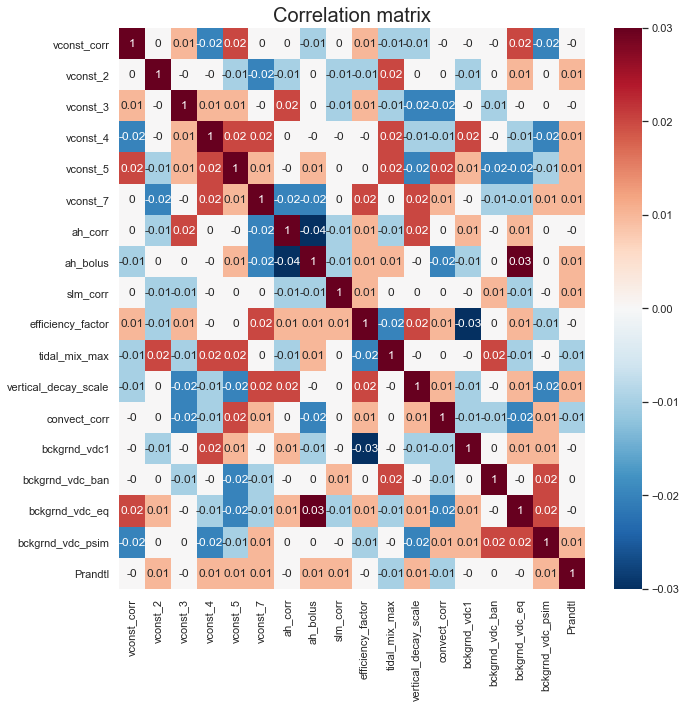

In [112]:
data = df_big.drop(columns=['Study', 'Run', 'outcome'])
features = data.columns
target = df_big['outcome']

fig = plt.figure(figsize=(10,10))
df_big.isnull().sum() # check for missing values in all the columns
sns.set(rc={'figure.figsize':(11.7,8.27)})
correlation_matrix = data.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, vmin = -0.03, vmax = 0.03, cmap="RdBu_r") # annot = True to print the values inside the square
plt.title("Correlation matrix", size=20)
fig.tight_layout()
plt.savefig('Figures/Dataset/correlationmatrix.png', dpi=100)
plt.show()

## Distribution of success and failure - 1D

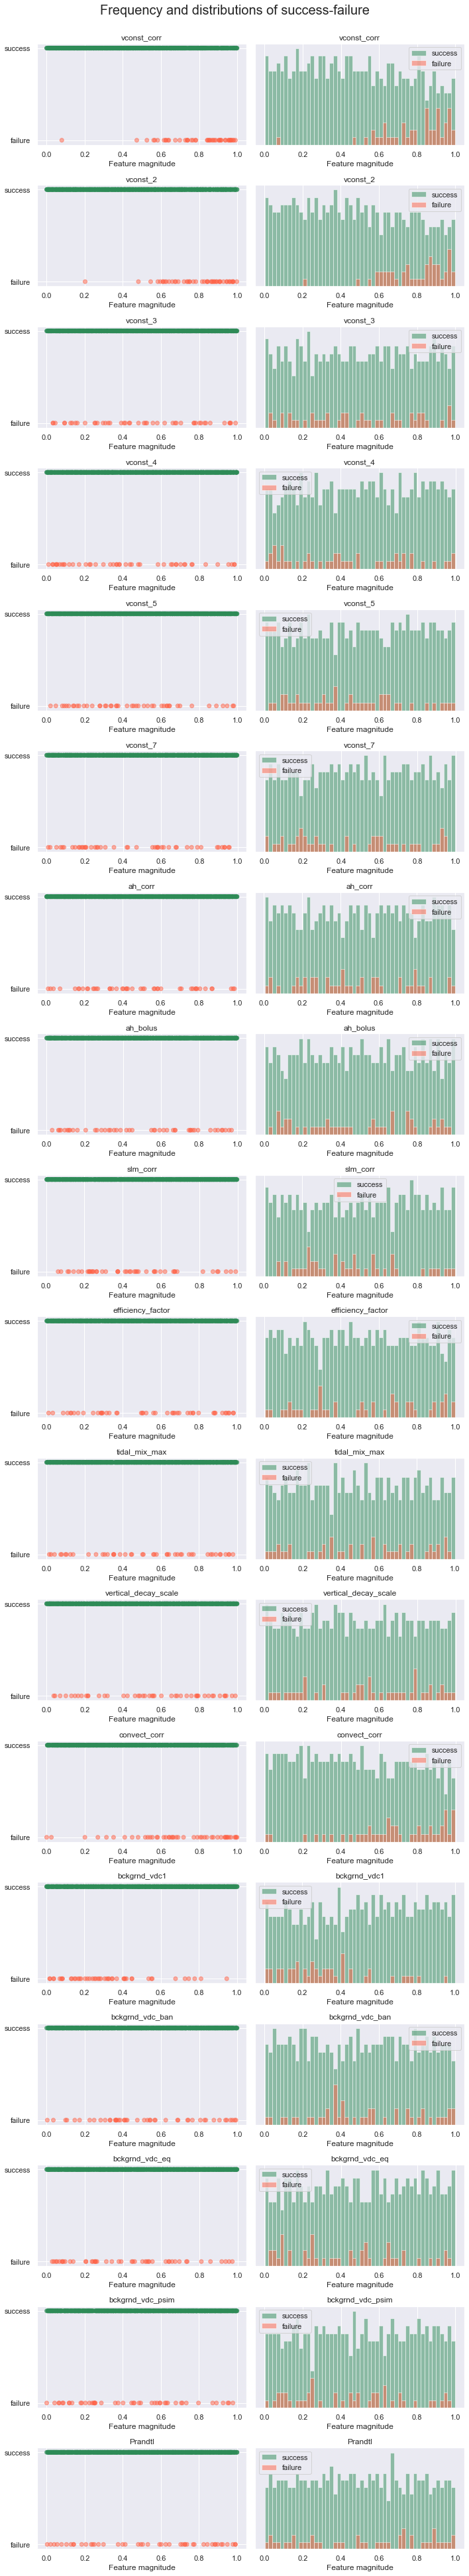

In [113]:
fig, axes = plt.subplots(int(len(features)),2,figsize=(10,len(features)*3))
failures = data[target == 0]
successes = data[target == 1]
ax = axes.ravel()
colors = np.where(target==0,'tomato','seagreen')

c=0
for i,col in enumerate(features):
    ax[c].scatter(data[col], target, marker='o', c=colors, alpha =0.5)
    ax[c].set_title(col)
    ax[c].set_xlabel(col)
    ax[c].set_xlabel("Feature magnitude")
    ax[c].set_yticks([0.,1.])
    ax[c].set_yticklabels(["failure", "success"])
    c +=1
    _, bins = np.histogram(data[col], bins =50)
    ax[c].hist(successes[col], bins = bins, alpha = 0.5, color="seagreen")
    ax[c].hist(failures[col], bins = bins, alpha = 0.5, color="tomato")
    ax[c].set_xlabel("Feature magnitude")
    ax[c].set_title(col)
    ax[c].set_yticks(())
    ax[c].legend(["success", "failure"])#, loc ="best")
    c +=1

plt.suptitle("Frequency and distributions of success-failure", size=20, y=1)
fig.tight_layout()
plt.grid(False)
plt.savefig('Figures/Dataset/distributions.png', dpi=100)
plt.show()

# Selection of most sensible parameters

As we can see form the previous plots the most sensible paramters are 'vconst_corr', 'vconst_2', 'convect_corr', 'bckgrnd_vdc1' (also said in the paper [Lucas D.D. at al.](https://gmd.copernicus.org/articles/6/1157/2013/)). So a selection will be made just on this four variables to create relevant plots for the report.

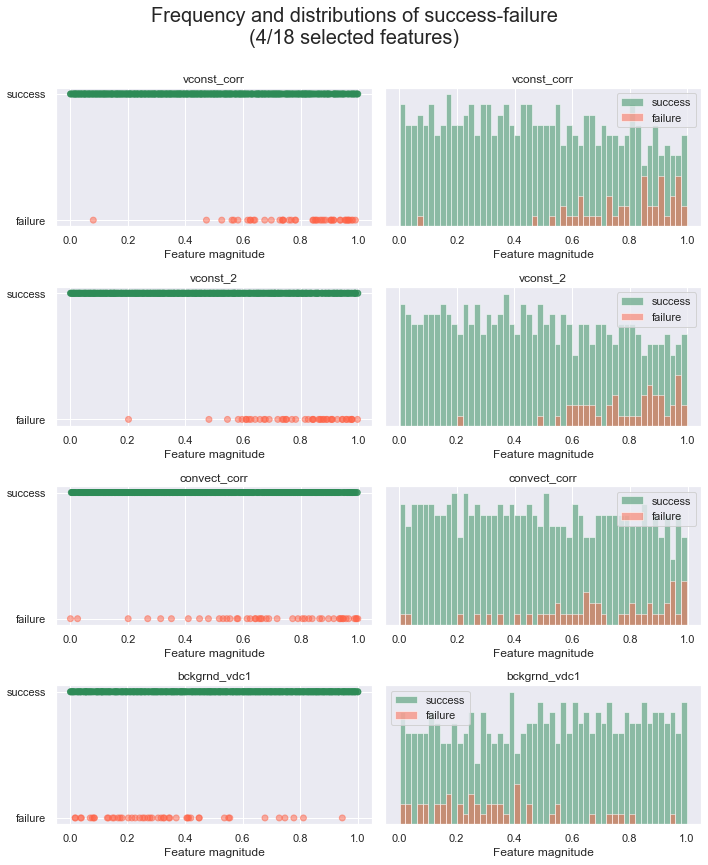

In [108]:
features_sel = [ 'vconst_corr', 'vconst_2', 'convect_corr', 'bckgrnd_vdc1']

fig, axes = plt.subplots(int(len(features_sel)),2,figsize=(10,len(features_sel)*3))
ax = axes.ravel()

c=0
for i,col in enumerate(features_sel):
    ax[c].scatter(data[col], target, marker='o', c=colors, alpha =0.5)
    ax[c].set_title(col)
    ax[c].set_xlabel(col)
    ax[c].set_xlabel("Feature magnitude")
    ax[c].set_yticks([0.,1.])
    ax[c].set_yticklabels(["failure", "success"])
    c +=1
    _, bins = np.histogram(data[col], bins =50)
    ax[c].hist(successes[col], bins = bins, alpha = 0.5, color="seagreen")
    ax[c].hist(failures[col], bins = bins, alpha = 0.5, color="tomato")
    ax[c].set_xlabel("Feature magnitude")
    ax[c].set_title(col)
    ax[c].set_yticks(())
    ax[c].legend(["success", "failure"])#, loc ="best")
    c +=1

plt.suptitle("Frequency and distributions of success-failure\n(4/18 selected features)", size=20, y=1)
fig.tight_layout()
plt.grid(False)
plt.savefig('Figures/Dataset/distributions_sel.png',dpi=100)
plt.show()

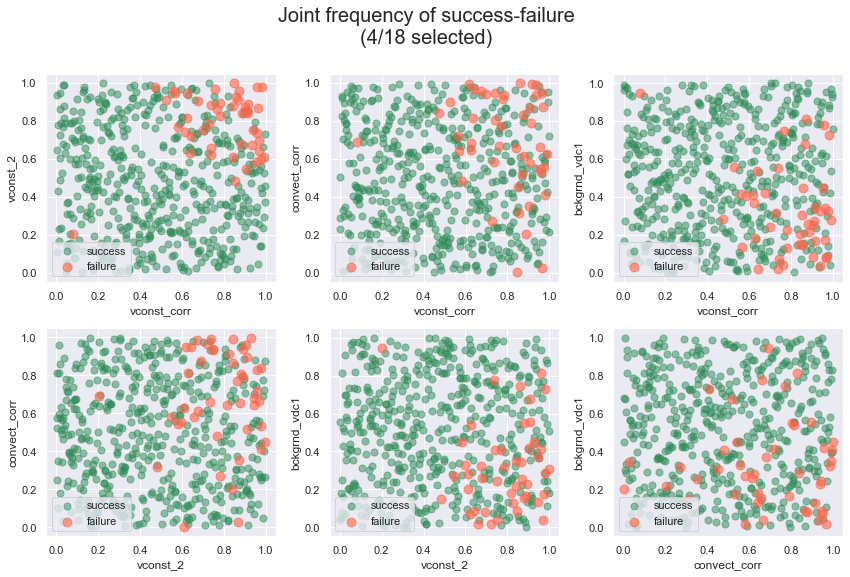

In [111]:
fig, axes = plt.subplots(2,3,figsize=(12,8))
ax = axes.ravel()

fs=features_sel
c=0
for i in range(len(fs)):

    for j in range(i+1,len(fs)):

        ax[c].scatter(successes[fs[i]], successes[fs[j]], marker='o', s=50,color="seagreen", alpha =0.5, label ="success")
        ax[c].scatter(failures[fs[i]], failures[fs[j]], marker='o', s=80,color="tomato", alpha =0.6, label = "failure")
        #ax[c].set_title(col)
        ax[c].set_xlabel(fs[i])
        ax[c].set_ylabel(fs[j])
        ax[c].legend(loc =3)
        c += 1

plt.suptitle("Joint frequency of success-failure\n(4/18 selected)", size=20, y=1)
fig.tight_layout()
plt.grid(False)
plt.savefig('Figures/Dataset/distributions_2D_sel.png',dpi =100)
plt.show()

## Principal Component Analysis

Since there is this little correlation, first step is to have an insight on how much we can condence the information, setting different values of the wanted cumulative variance condensed in the $n$ variables. The more $n$ is large the more the PCA looses its effectiveness.

In [118]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

x = data.values
x = StandardScaler().fit_transform(x) # normalizing the features

pca = PCA(n_components=0.95)
x_reduced = pca.fit_transform(x)

print("Variance of 95%:", np.shape(x_reduced)[1], "PC")

pca = PCA(n_components=0.70)
x_reduced = pca.fit_transform(x)

print("Variance of 70%:", np.shape(x_reduced)[1], "PC")

pca = PCA(n_components=0.55)
x_reduced = pca.fit_transform(x)

print("Variance of 55%:", np.shape(x_reduced)[1], "PC")

Variance of 95%: 18 PC
Variance of 70%: 13 PC
Variance of 55%: 10 PC


With a cumulative variance of 95%, all the 18 features are kept. Even lowering the variance the result doesn't get any better. There is no point to do the PCA when the fautures are so little correlated, otherwise we loose too much information.

In [94]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

x = data.values
x = StandardScaler().fit_transform(x) # normalizing the features
print(np.mean(x),np.std(x))

pca = PCA(n_components=0.95)
x_reduced = pca.fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
print(x_reduced)
print(principalComponents)

from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
x_kreduced = rbf_pca.fit_transform(x)

-3.5454035683502944e-17 0.9999999999999999
[[-1.04103789 -1.6694667  -0.61331988 ... -0.42329508  0.43685503
  -0.84115618]
 [ 1.31452677  0.03679751 -1.37050321 ...  1.09492012  0.33802533
  -0.71679032]
 [ 2.15417561 -0.78125289  0.77645792 ...  0.97166707  0.91020854
  -0.23371981]
 ...
 [-0.68649909  1.65565604  0.79606349 ...  0.19437256  0.51300239
  -0.21306749]
 [ 2.10558606  0.14903476  0.96011664 ...  0.96589311 -1.07016063
   1.02857232]
 [-0.58900866  0.39999528  1.15625167 ...  0.07097375  1.18838253
   0.46498961]]
[[-0.90806613  0.73161345]
 [-0.64705378 -1.50888103]
 [-1.83028318  0.32085775]
 ...
 [ 1.3669823   0.73327791]
 [-1.30375287  0.25717433]
 [ 0.81604386  0.92680833]]


     principal component 1  principal component 2
535               0.187189              -0.313431
536               0.197930               0.004753
537              -0.114438               0.268623
538              -0.134787              -0.193463
539               0.152807               0.093123
Explained variation per principal component: [0.05968521 0.0581144 ]


<Figure size 842.4x595.44 with 0 Axes>

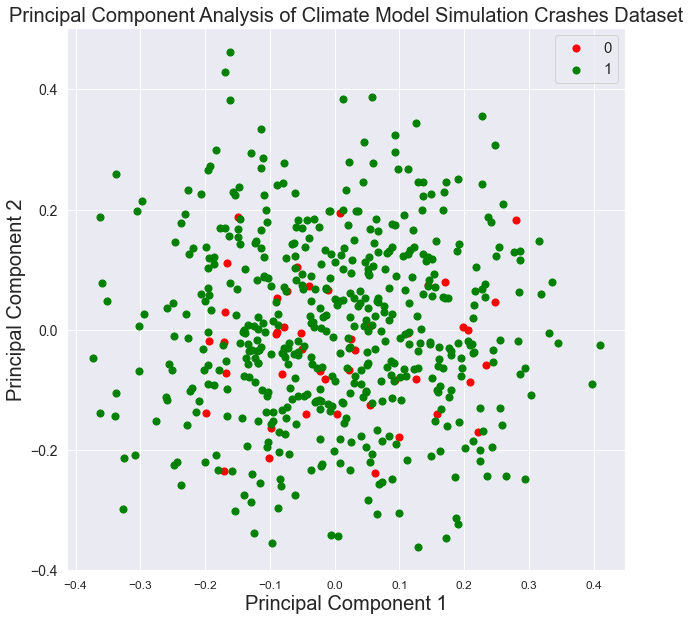

In [95]:
targets = [0,1]
colors = ['red', 'green']
principal_Df = pd.DataFrame(data = x_kreduced
             , columns = ['principal component 1', 'principal component 2'])
print(principal_Df.tail())
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.title("Principal Component Analysis of Climate Model Simulation Crashes Dataset",fontsize=20)

for target, color in zip(targets,colors):
    indicesToKeep = df_big['outcome'] == target
    plt.scatter(principal_Df.loc[indicesToKeep, 'principal component 1']
               , principal_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

In [87]:
from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(x)
np.shape(X_reduced)

(540, 2)